In [2]:
from chexnet import get_chexnet_model
from keras.layers import Input, Dense, Dropout
from keras.utils import print_summary
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import os
import pandas as pd
from generator import AugmentedImageSequence
from test_CheXNet import target_classes
#from weights import get_class_weights

Using TensorFlow backend.


In [2]:
# get base model, model
base_model, chexnet_model = get_chexnet_model()

In [3]:
chexnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [3]:
from train_tCheXNet import get_model

In [54]:
base_model, model = get_model()

In [55]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image

In [5]:
#Defining paths
TRAIN_PATH = "../Covid-19-Detection/CovidDataset/Train"
VAL_PATH = "../Covid-19-Detection/CovidDataset/Val"

In [57]:
opt = Adam(
    lr=0.0005,
    beta_1=0.9,
    beta_2=0.999,
#     epsilon=None,
    decay=0.0,
    amsgrad=False
)

# Let's train the model using Adam
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

In [6]:
#Moulding train images
train_datagen = image.ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2, horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [7]:
#Reshaping test and validation images 
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')
validation_generator = test_datagen.flow_from_directory(
    VAL_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 224 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [60]:
#Training the model
hist_new = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps=2
)

Epoch 1/20
50/50 [==============================] - 53s 1s/step - loss: 0.4659 - accuracy: 0.8288 - val_loss: 0.3647 - val_accuracy: 0.9000
Epoch 2/20
50/50 [==============================] - 46s 928ms/step - loss: 0.2825 - accuracy: 0.9069 - val_loss: 0.2502 - val_accuracy: 0.8667
Epoch 3/20
50/50 [==============================] - 49s 972ms/step - loss: 0.1944 - accuracy: 0.9400 - val_loss: 0.2189 - val_accuracy: 0.9000
Epoch 4/20
50/50 [==============================] - 48s 967ms/step - loss: 0.1584 - accuracy: 0.9588 - val_loss: 0.2204 - val_accuracy: 0.8667
Epoch 5/20
50/50 [==============================] - 48s 960ms/step - loss: 0.1410 - accuracy: 0.9531 - val_loss: 0.5933 - val_accuracy: 0.7833
Epoch 6/20
50/50 [==============================] - 48s 968ms/step - loss: 0.2246 - accuracy: 0.9075 - val_loss: 0.3151 - val_accuracy: 0.9000
Epoch 7/20
50/50 [==============================] - 48s 957ms/step - loss: 0.1001 - accuracy: 0.9706 - val_loss: 0.3149 - val_accuracy: 0.8833
Ep

In [61]:
#Getting summary
summary=hist_new.history
# print(summary)

In [8]:
def plot_training_metrics(history):
    plt.figure(figsize=(10,5))
    # summarize history for loss
    plt.subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
#     plt.show()
    plt.subplot(122)
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

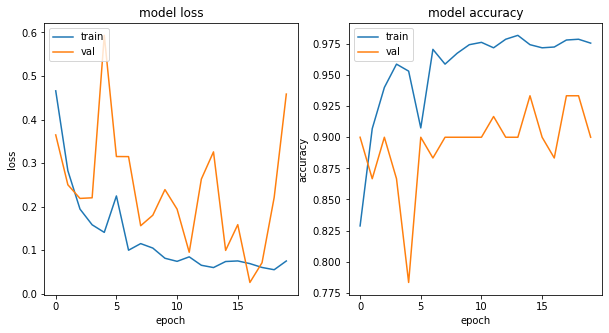

In [63]:
plot_training_metrics(hist_new)

In [25]:
model.save("model_covid.h5")

In [26]:
model.evaluate_generator(train_generator)

[0.18233542144298553, 0.8616071343421936]

In [27]:
model.evaluate_generator(validation_generator)

[0.2083616703748703, 0.8666666746139526]

In [30]:
import os
train_generator.class_indices

{'Covid': 0, 'Normal': 1}

In [16]:
def eval(model, path=VAL_PATH):
    y_actual, y_test = [],[]
    for i in os.listdir(path + "/Normal/"):
        img=image.load_img(path + "/Normal/"+i,target_size=(224,224))
        img=image.img_to_array(img)/255.0
        img=np.expand_dims(img,axis=0)
        # pred=model.predict_classes(img)
        pred=model.predict(img)
        if pred[0,0]>=0.5:
            y_test.append(1)
        else:
            y_test.append(0)
        # y_test.append(pred[0,0])
        y_actual.append(1)


    for i in os.listdir(path + "/Covid/"):
        img=image.load_img(path + "/Covid/"+i,target_size=(224,224))
        img=image.img_to_array(img)/255.0
        img=np.expand_dims(img,axis=0)
        # pred=model.predict_classes(img)
        pred=model.predict(img)
        if pred[0,0]>=0.5:
            y_test.append(1)
        else:
            y_test.append(0)
        #y_test.append(pred[0,0])
        y_actual.append(0)
        
    y_actual=np.array(y_actual)
    y_test=np.array(y_test)
    cn=confusion_matrix(y_actual,y_test)
    return cn

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# cn=confusion_matrix(y_actual,y_test)

In [68]:
cn = eval(model)

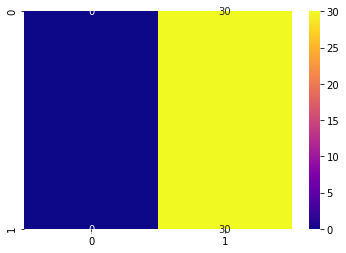

In [69]:
sns.heatmap(cn,cmap="plasma",annot=True) #0: Covid ; 1: Normal

## Fine tune all layers

In [76]:
for layer in model.layers:
    layer.trainable = True

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

/home/akasarla/.local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [77]:
opt = Adam(
    lr=0.0005,
    beta_1=0.9,
    beta_2=0.999,
#     epsilon=None,
    decay=0.0,
    amsgrad=False
)

# Let's train the model using Adam
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [78]:
hist_new = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps=10
)

Epoch 1/20
50/50 [==============================] - 76s 2s/step - loss: 0.0509 - accuracy: 0.9812 - val_loss: 0.0413 - val_accuracy: 0.9667
Epoch 2/20
50/50 [==============================] - 48s 951ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3038 - val_accuracy: 0.9833
Epoch 3/20
50/50 [==============================] - 49s 979ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0035 - val_accuracy: 0.9833
Epoch 4/20
50/50 [==============================] - 49s 979ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.1472 - val_accuracy: 0.9333
Epoch 5/20
50/50 [==============================] - 50s 999ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.4131 - val_accuracy: 0.9667
Epoch 6/20
50/50 [==============================] - 50s 1s/step - loss: 0.0025 - accuracy: 0.9987 - val_loss: 0.0026 - val_accuracy: 0.9833
Epoch 7/20
50/50 [==============================] - 52s 1s/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 5.2915e-04 - val_accuracy: 0.9833
Epoc

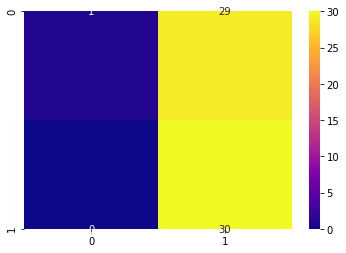

In [79]:
cn = eval(model)
sns.heatmap(cn,cmap="plasma",annot=True) #0: Covid ; 1: Normal

In [80]:
model.save("model_all_layers.h5")

In [81]:
base_model, model = get_model()
opt = Adam(
    lr=0.0001,
    beta_1=0.9,
    beta_2=0.999,
#     epsilon=None,
    decay=0.0,
    amsgrad=False
)
for layer in model.layers:
    layer.trainable = True

# Let's train the model using Adam
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [82]:
hist_new = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps=2
)

Epoch 1/20
50/50 [==============================] - 74s 1s/step - loss: 0.5053 - accuracy: 0.8600 - val_loss: 0.3683 - val_accuracy: 0.9333
Epoch 2/20
50/50 [==============================] - 47s 944ms/step - loss: 0.1828 - accuracy: 0.9906 - val_loss: 0.0975 - val_accuracy: 0.9333
Epoch 3/20
50/50 [==============================] - 49s 988ms/step - loss: 0.0542 - accuracy: 0.9975 - val_loss: 0.1147 - val_accuracy: 0.9500
Epoch 4/20
50/50 [==============================] - 49s 983ms/step - loss: 0.0265 - accuracy: 0.9975 - val_loss: 0.0947 - val_accuracy: 0.9667
Epoch 5/20
50/50 [==============================] - 48s 961ms/step - loss: 0.0149 - accuracy: 0.9987 - val_loss: 0.0060 - val_accuracy: 0.9833
Epoch 6/20
50/50 [==============================] - 47s 943ms/step - loss: 0.0142 - accuracy: 0.9956 - val_loss: 0.0826 - val_accuracy: 0.9500
Epoch 7/20
50/50 [==============================] - 48s 952ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 0.9833
Ep

KeyboardInterrupt: 

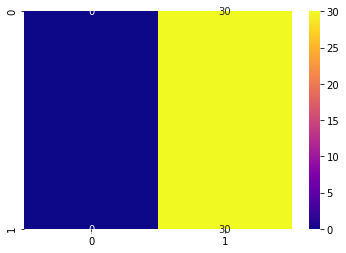

In [83]:
cn = eval(model)
sns.heatmap(cn,cmap="plasma",annot=True) #0: Covid ; 1: Normal

In [84]:
model.save("model_all_layers_e4.h5")

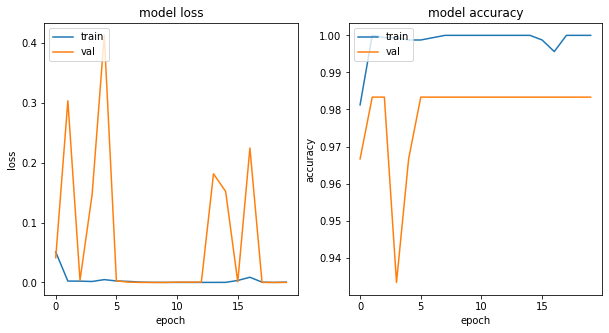

In [93]:
plot_training_metrics(hist_new)

### Simple CNN model

In [111]:
#Training model
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

In [112]:
#Training the model
hist_simple_cnn = model.fit_generator(
    train_generator,
    steps_per_epoch=8,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps=2
)

Epoch 1/10
8/8 [==============================] - 7s 860ms/step - loss: 1.0391 - accuracy: 0.5352 - val_loss: 0.6642 - val_accuracy: 0.5000
Epoch 2/10
8/8 [==============================] - 5s 677ms/step - loss: 0.6104 - accuracy: 0.6680 - val_loss: 0.5739 - val_accuracy: 0.9000
Epoch 3/10
8/8 [==============================] - 7s 843ms/step - loss: 0.3833 - accuracy: 0.8086 - val_loss: 0.2746 - val_accuracy: 0.9500
Epoch 4/10
8/8 [==============================] - 7s 866ms/step - loss: 0.2884 - accuracy: 0.9023 - val_loss: 0.1271 - val_accuracy: 0.9667
Epoch 5/10
8/8 [==============================] - 7s 851ms/step - loss: 0.2761 - accuracy: 0.9180 - val_loss: 0.1413 - val_accuracy: 0.9500
Epoch 6/10
8/8 [==============================] - 7s 884ms/step - loss: 0.1660 - accuracy: 0.9531 - val_loss: 0.0763 - val_accuracy: 0.9667
Epoch 7/10
8/8 [==============================] - 7s 846ms/step - loss: 0.1495 - accuracy: 0.9492 - val_loss: 0.0748 - val_accuracy: 0.9833
Epoch 8/10
8/8 [====

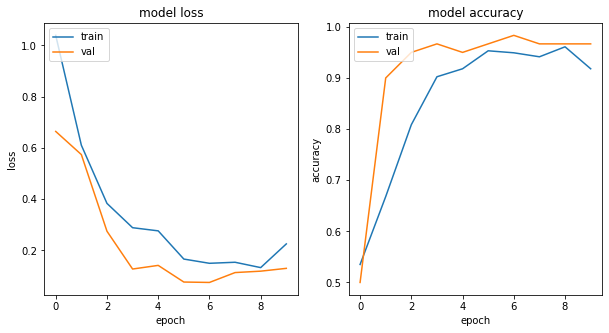

In [113]:
plot_training_metrics(hist_simple_cnn)

In [115]:
cn

array([[30,  0],
       [ 2, 28]])

In [116]:
!pip install --user matplotlib==3.1.0

     |████████████████████████████████| 13.1MB 5.9MB/s eta 0:00:01


In [ ]:
cn = eval(model)

[[30, 0], [2, 29]]


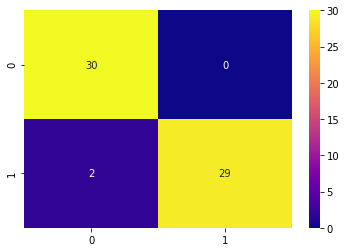

In [11]:
print(cn)
sns.heatmap(cn,cmap="plasma",annot=True) #0: Covid ; 1: Normal

In [120]:
model.save("model_vanilla_cnn.h5")

### Getting back to CheXNet

In [121]:
base_model, model = get_model()
opt = Adam(
    lr=0.001,
    beta_1=0.9,
    beta_2=0.999,
#     epsilon=None,
    decay=0.0,
    amsgrad=False
)
for layer in model.layers:
    layer.trainable = True

# Let's train the model using Adam
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [122]:
hist_new = model.fit_generator(
    train_generator,
    steps_per_epoch=8,
    epochs = 50,
    validation_data = validation_generator,
    validation_steps=2
)

Epoch 1/50
8/8 [==============================] - 36s 5s/step - loss: 0.8780 - accuracy: 0.5781 - val_loss: 0.5311 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 4s 554ms/step - loss: 0.4078 - accuracy: 0.7695 - val_loss: 0.4771 - val_accuracy: 0.8667
Epoch 3/50
8/8 [==============================] - 8s 973ms/step - loss: 0.1319 - accuracy: 0.9805 - val_loss: 0.5054 - val_accuracy: 0.9000
Epoch 4/50
8/8 [==============================] - 7s 936ms/step - loss: 0.0300 - accuracy: 1.0000 - val_loss: 0.1400 - val_accuracy: 0.9167
Epoch 5/50
8/8 [==============================] - 7s 910ms/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.9667
Epoch 6/50
8/8 [==============================] - 7s 918ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.2029 - val_accuracy: 0.9833
Epoch 7/50
8/8 [==============================] - 7s 888ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 6.9643e-04 - val_accuracy: 0.9500
Epoch 8/50
8/8 [==

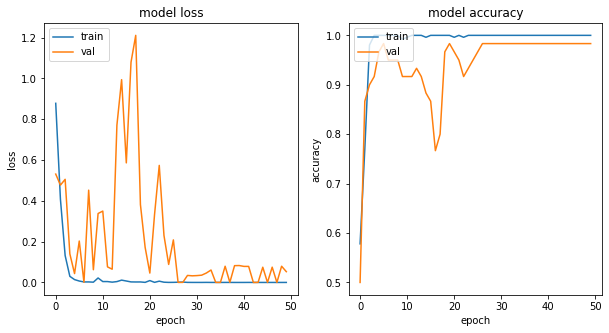

In [123]:
plot_training_metrics(hist_new)

In [125]:
model.save("model_all_layers_e3.h5")

In [ ]:
cn = eval(model)

[[30, 0], [1, 29]]


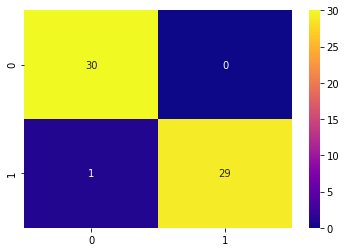

In [12]:
print(cn)
sns.heatmap(cn,cmap="plasma",annot=True) #0: Covid ; 1: Normal

In [13]:
base_model, model = get_model()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
model.load_weights("model_all_layers_e3.h5")

In [ ]:
cn = eval(model, path=TRAIN_PATH)

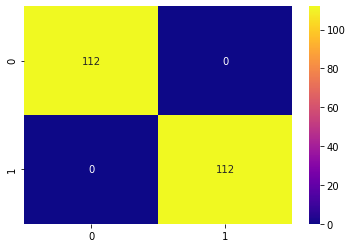

In [21]:
sns.heatmap(cn,cmap="plasma",annot=True, fmt='g') #0: Covid ; 1: Normal